In [13]:
import sys, os
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as opt
import pandas as pd
from torch.nn import Module, Parameter
from torch import softmax, log_softmax
from torch_sparse import SparseTensor
from sklearn.cluster import KMeans
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import time
from umap import UMAP
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

In [5]:
def plot_latent(z, anno = None, save = None, figsize = (20,10), axis_label = "Latent", **kwargs):

    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)

    ax = fig.add_subplot()
    cluster_types = [x for x in np.unique(anno)]
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]

        if index.shape[0] != 0:
            ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    # axs[0].legend(fontsize = font_size)
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    # ax.set_title("scATAC-Seq", fontsize = 25)

    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  

    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)

In [2]:
class cfrmSparseModel(Module):
    def __init__(self, dir, N=3, batch_size=1.0, interval=10, lr=1e-3, init='svd'):
        super().__init__()
        self.batch_size = batch_size
        self.interval = interval
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 1, 1])
        # data
        counts_rna = sp.load_npz(os.path.join(dir, 'C1xG.npz'))
        counts_atac = sp.load_npz(os.path.join(dir, 'C2xR.npz')).astype(np.float32)
        Cor = sp.load_npz(os.path.join(dir, 'GxR.npz')).astype(np.float32)

        self.G = torch.FloatTensor(counts_rna.todense())
        self.R = torch.FloatTensor(counts_atac.todense())
        self.M = torch.FloatTensor(Cor.todense())

        if init == 'svd':
            self.A = Parameter(torch.eye(N))
            u_g, s_g, v_g = torch.svd_lowrank(self.G, N)
            self.C_1 = Parameter(u_g)
            self.A_1g_l = Parameter(s_g.sqrt().reshape(-1, 1))
            self.A_1g_r = Parameter(s_g.sqrt().reshape(1, -1))
            self.C_g = Parameter(v_g)
            u_r, s_r, v_r = torch.svd_lowrank(self.R, N)
            self.C_2 = Parameter(u_r)
            self.A_2r_l = Parameter(s_r.sqrt().reshape(-1, 1))
            self.A_2r_r = Parameter(s_r.sqrt().reshape(1, -1))
            self.C_r = Parameter(v_r)
            self.A_gr_l = Parameter(torch.ones(N, 1))
            self.A_gr_r = Parameter(torch.ones(1, N))
        else:
            self.C_1 = Parameter(torch.randn(self.G.shape[0], N))
            self.C_2 = Parameter(torch.randn(self.R.shape[0], N))
            self.C_g = Parameter(torch.randn(self.G.shape[1], N))
            self.C_r = Parameter(torch.randn(self.R.shape[1], N))
            self.A = Parameter(torch.randn(N, N))
            self.A_1g_l = Parameter(torch.randn(N, 1))
            self.A_1g_r = Parameter(torch.randn(1, N))
            self.A_2r_l = Parameter(torch.randn(N, 1))
            self.A_2r_r = Parameter(torch.randn(1, N))
            self.A_gr_l = Parameter(torch.randn(N, 1))
            self.A_gr_r = Parameter(torch.randn(1, N))
        assert self.M.shape[0] == self.G.shape[1]
        assert self.M.shape[1] == self.R.shape[1]
        self.meta_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)
        self.meta_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)
        self.regions = pd.read_csv(os.path.join(dir, "regions.txt"), header=None)
        self.genes = pd.read_csv(os.path.join(dir, "genes.txt"), header=None)

        self.optimizer = opt.Adam(self.parameters(), lr=lr)

#         with torch.no_grad():
#             loss, *_ = self.batch_loss('valid')
#             print('Initial Loss is {:.5f}'.format(loss.item()))


    def batch_loss(self, mode='C_c'):
        mask_1 = np.random.choice(self.G.shape[0], int(self.G.shape[0] * self.batch_size), replace=False)
        mask_2 = np.random.choice(self.R.shape[0], int(self.R.shape[0] * self.batch_size), replace=False)
        mask_g = np.random.choice(self.G.shape[1], int(self.G.shape[1] * self.batch_size), replace=False)
        mask_r = np.random.choice(self.R.shape[1], int(self.R.shape[1] * self.batch_size), replace=False)
        if mode == 'C_12':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.C_1[mask_1, :] @ (self.A_1g_l * self.A * self.A_1g_r).detach() @
                     self.C_g[mask_g].detach().t()).pow(2).mean()
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.C_2[mask_2] @ (self.A_2r_l * self.A * self.A_2r_r).detach() @
                     self.C_r[mask_r].detach().t()).pow(2).mean()
            loss4 = self.C_1[mask_1].abs().mean() + self.C_2[mask_2].abs().mean()
            loss3 = 0
        elif mode == 'C_gr':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.C_1[mask_1].detach() @ (self.A_1g_l * self.A * self.A_1g_r).detach() @ self.C_g[mask_g].t()).pow(2).mean()
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.C_2[mask_2].detach() @ (self.A_2r_l * self.A * self.A_2r_r).detach() @ self.C_r[mask_r].t()).pow(2).mean()
            loss3 = (self.M[np.ix_(mask_g, mask_r)] - self.C_g[mask_g] @ (self.A_gr_l * self.A * self.A_gr_r).detach() @ self.C_r[mask_r].t()).pow(2).mean()
            loss4 = self.C_g[mask_g].abs().mean() + self.C_r[mask_r].abs().mean()
        elif mode == 'A':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.C_1[mask_1].detach() @ (self.A_1g_l * self.A * self.A_1g_r) @ self.C_g[mask_g].detach().t()).pow(2).mean()
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.C_2[mask_2].detach() @ (self.A_2r_l * self.A * self.A_2r_r) @ self.C_r[mask_r].detach().t()).pow(2).mean()
            loss3 = (self.M[np.ix_(mask_g, mask_r)] - self.C_g[mask_g].detach() @ (self.A_gr_l * self.A * self.A_gr_r) @ self.C_r[mask_r].detach().t()).pow(2).mean()
            loss4 = 0
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - self.C_1 @ (self.A_1g_l * self.A * self.A_1g_r) @ self.C_g.t()).pow(2).mean()
                loss2 = (self.R - self.C_2 @ (self.A_2r_l * self.A * self.A_2r_r) @ self.C_r.t()).pow(2).mean()
                loss3 = (self.M - self.C_g @ (self.A_gr_l * self.A * self.A_gr_r) @ self.C_r.t()).pow(2).mean()
                loss4 = (self.C_1.abs().mean() + self.C_2.abs().mean() + self.C_g.abs().mean() + self.C_r.abs().mean())
        else:
            raise NotImplementedError
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4

        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4
    #
    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            # for mode in ['C_c']:
            for mode in ['C_12', 'C_gr', 'C_12', 'C_gr', 'A']:
                loss, *_ = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
            if (t+1) % self.interval == 0:
                loss, loss1, loss2, loss3, loss4 = self.batch_loss('valid')
                print('Epoch {}, Training Loss: {:.4f}'.format(t + 1, loss.item()))
                info = [
                    'loss RNA: {:.5f}'.format(loss1.item()),
                    'loss ATAC: {:.5f}'.format(loss2.item()),
                    'loss gene act: {:.5f}'.format(loss3.item()),
                    'loss sparse: {:.5f}'.format(loss4.item()),
                ]
                for i in info:
                    print("\t", i)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(self.state_dict(), '../check_points/real.pt')
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t + 1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        self.load_state_dict(torch.load('../check_points/real.pt'))
                        count = 0

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = cfrmSparseModel(dir = '../data/real/BMMC/', N=25, lr=1e-3, interval=1, batch_size=0.2).to(device)
model.load_state_dict(torch.load('../check_points/real.pt'))

<All keys matched successfully>

None


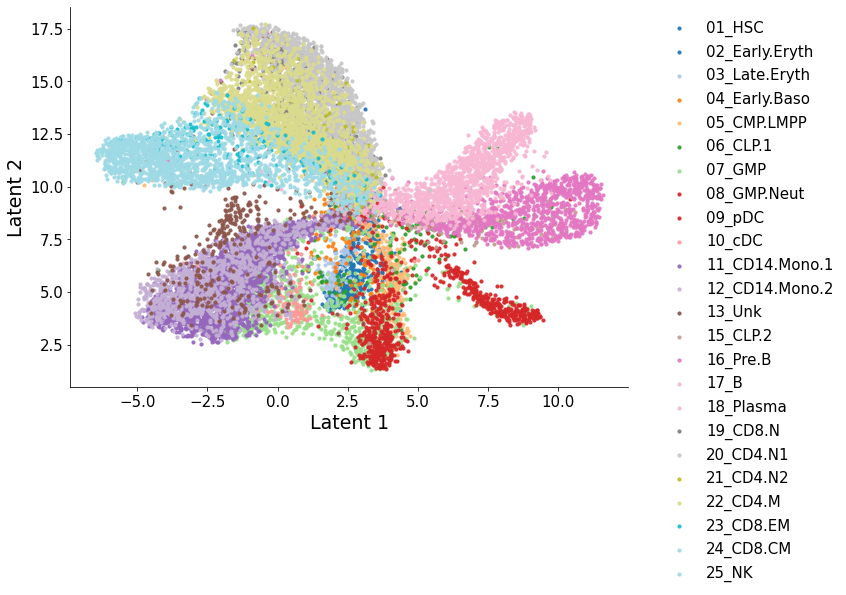

In [9]:
z_atac = model.C_2.detach().numpy()
umap_op = UMAP(n_components = 2, n_neighbors = 400, min_dist = 0.8)
umap_atac = umap_op.fit_transform(z_atac)
plot_latent(z = umap_atac, anno = model.meta_atac["cluster"].values, figsize = (10,7))

None


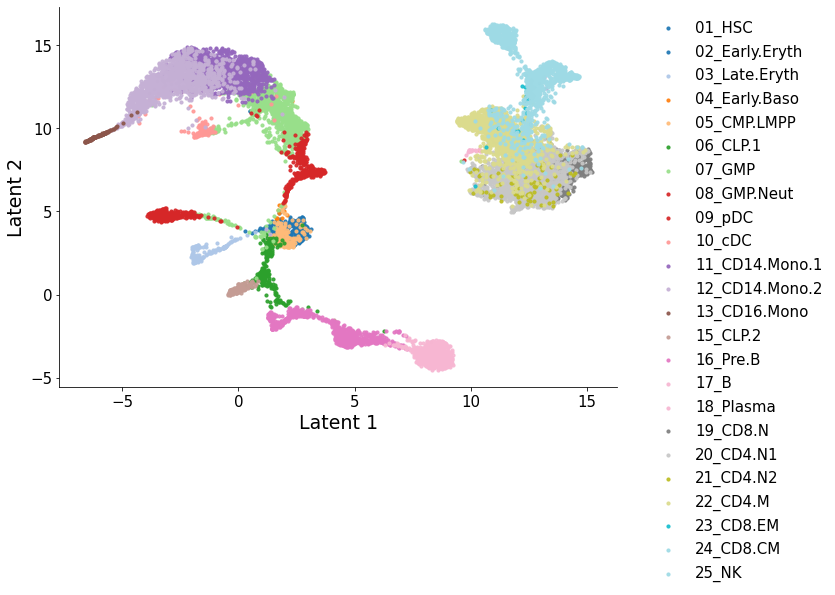

In [10]:
z_rna = model.C_1.detach().numpy()
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.3)
umap_rna = umap_op.fit_transform(z_rna)
plot_latent(z = umap_rna, anno = model.meta_rna["cluster"].values, figsize = (10,7), save = None)

In [15]:
c1xg = load_npz("../data/real/BMMC/C1xG.npz")
c2xr = load_npz("../data/real/BMMC/C2xR.npz")
meta_rna = pd.read_csv("../data/real/BMMC/meta_rna.csv", index_col = 0)
meta_atac = pd.read_csv("../data/real/BMMC/meta_atac.csv", index_col = 0)
regions = pd.read_csv("../data/real/BMMC/regions.txt", header = None)
genes = pd.read_csv("../data/real/BMMC/genes.txt", header = None)